<a href="https://colab.research.google.com/github/boradj/Abstract-Simplifier/blob/main/HAR_model/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Necessary Packages**
---


In [ ]:
import pandas as pd # for loading the datasets
import numpy as np  # for performing numeric computation
import pickle#to serialize objects for permanent storage
import matplotlib.pyplot as plt # for ploating 
from scipy import stats # for different scietific computation eg. statistical function
import tensorflow as tf # backend development
import seaborn as sns # sugarcoating for beautifying our graph
from sklearn import metrics # training and testing and spliting of data and metrics to judge our model
from sklearn.model_selection import train_test_split

#matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
RANDOM_SEED = 42
#Load the Drive helper and mount
from google.colab import drive
#This will prompt for authorization # to take permission from user to use google drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
columns = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('/content/drive/My Drive/WISDM_ar_v1.1_raw.txt', header = None, names = columns)
df = df.dropna()
df.head()


,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x-axis     1098203 non-null  float64
 4   y-axis     1098203 non-null  float64
 5   z-axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


**EXPLORATION**
---
The columns we will be most interested in are activity, x-axis, y-axis, and z-axis. 

In [ ]:
countOfActivity = df['activity'].value_counts()
print(countOfActivity)

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64


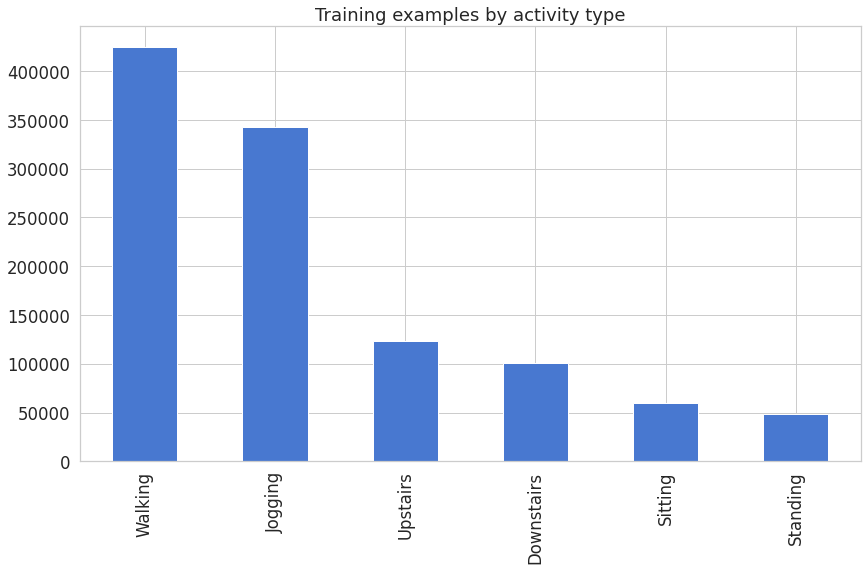

In [ ]:
countOfActivity.plot(kind='bar', title='Training examples by activity type', figsize=(14,8));

**No of samples belonging to each volunteer:**
---
The columns we will be most interested in are activity, x-axis, y-axis, z-axis.

In [ ]:
countOfActivityPerPerson=df['user'].value_counts()
print(countOfActivityPerPerson)
totalActivity=countOfActivityPerPerson.sum() #summation of all activities of all test persons
print('Total number of activity recorded ='+ str(totalActivity))


20    56632
19    45383
31    44282
8     41188
29    38245
14    38192
13    37093
34    35947
32    35506
21    35436
3     35161
27    34958
10    34883
18    32811
12    32641
26    32578
36    32261
11    31658
7     30967
1     29978
6     29704
33    29453
5     28509
15    28154
24    25736
23    25673
30    25335
2     23525
35    22394
22    22310
17    22020
28    21358
16    20470
25    13468
9     12923
4     11371
Name: user, dtype: int64
Total number of activity recorded =1098203


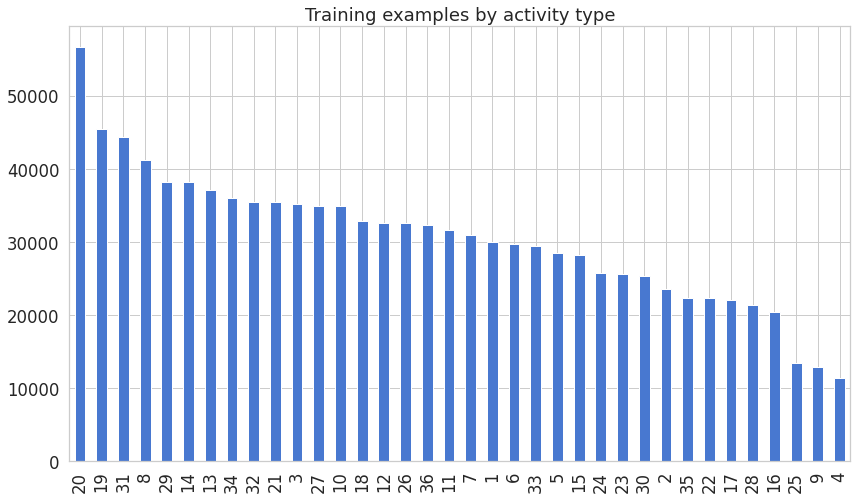

In [ ]:
countOfActivityPerPerson.plot(kind='bar', title='Training examples by activity type', figsize=(14,8));

**How does accelerometer data looks like visually:**
---

In [ ]:
def plot_activity(activity, df):
  extractRowsOfActivity = (df['activity'] == activity) #output will be true/false
  data = df[extractRowsOfActivity] # it will give only rows corresponding to specific activity
  data = data[['x-axis','y-axis','z-axis']] # only select rows corresponding to x,y and z axis
  data = data[:200] # limit the number of rows to initial 200 of ploatting
  ax = data.plot(subplots=True, figsize=(16,12), title=activity) # Plotting individual column of data frame

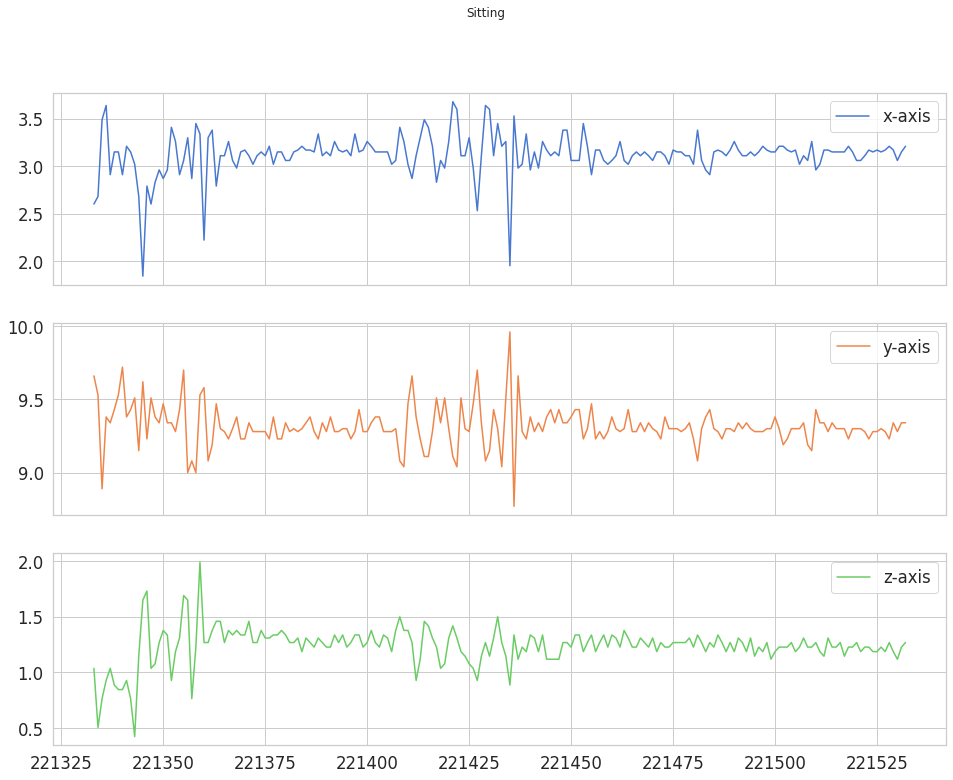

In [ ]:
plot_activity("Sitting",df)

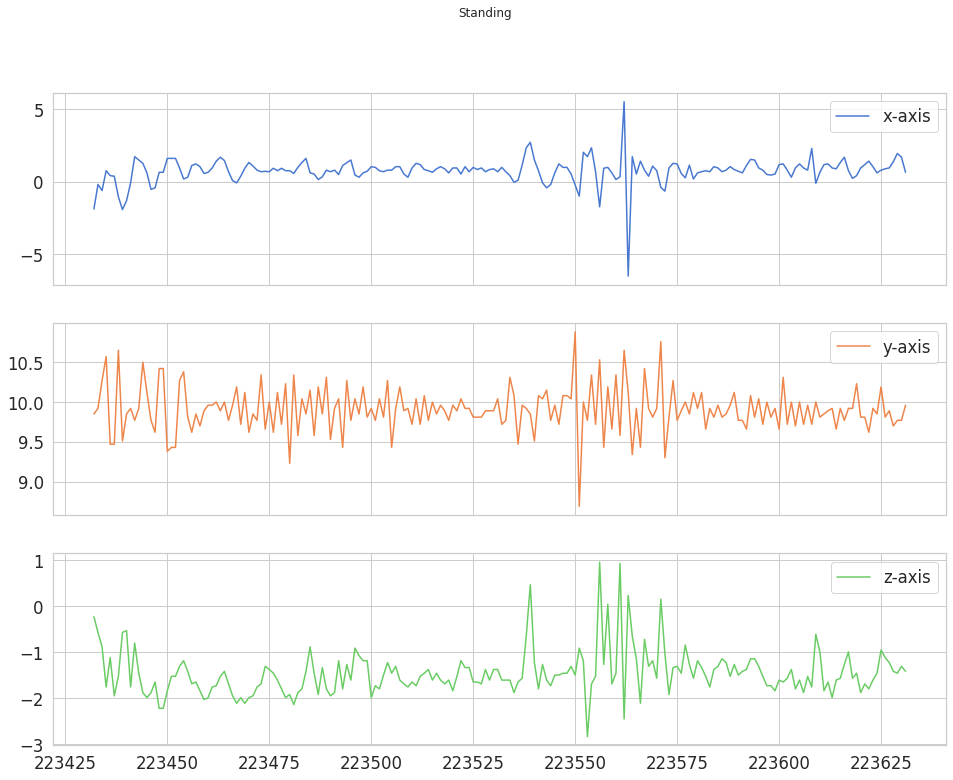

In [ ]:
plot_activity("Standing",df)

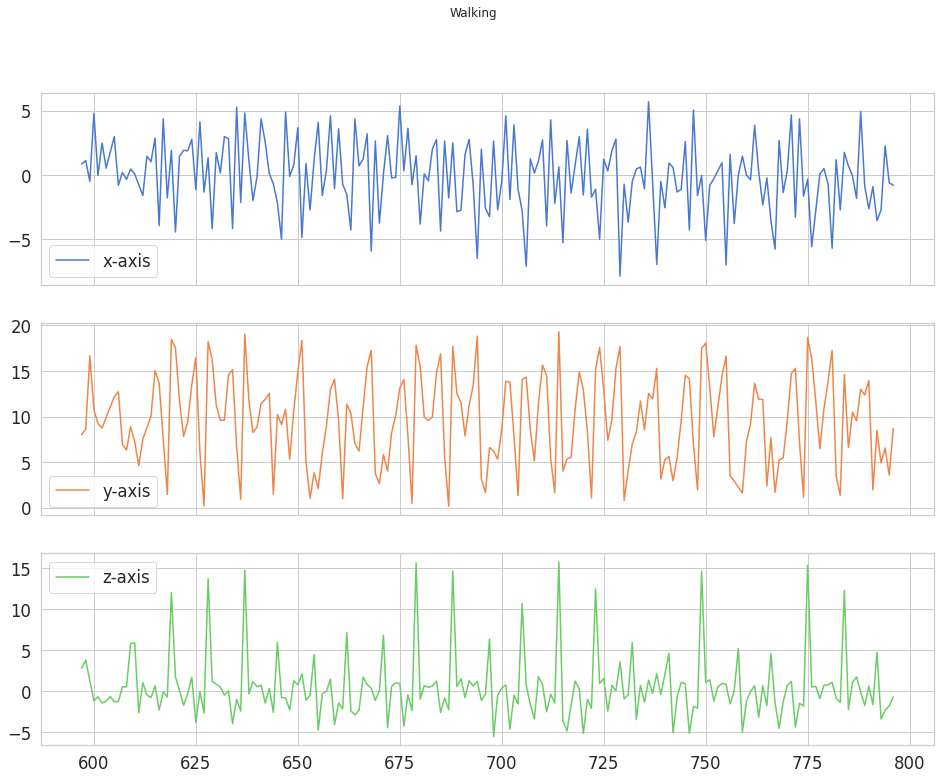

In [ ]:
plot_activity("Walking",df)

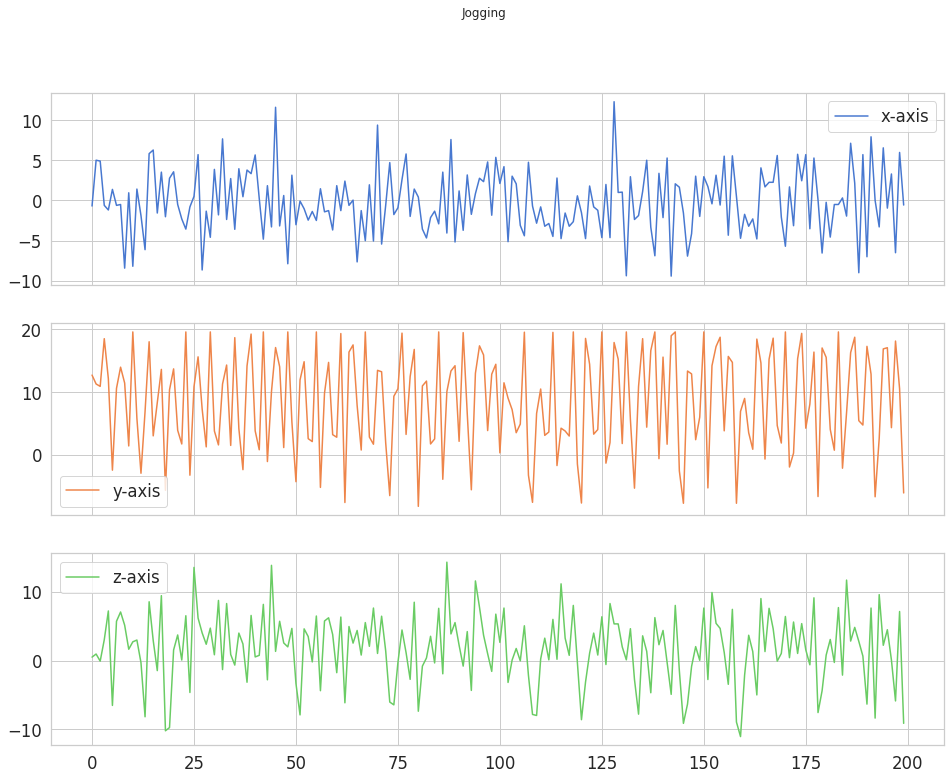

In [ ]:
plot_activity("Jogging",df)

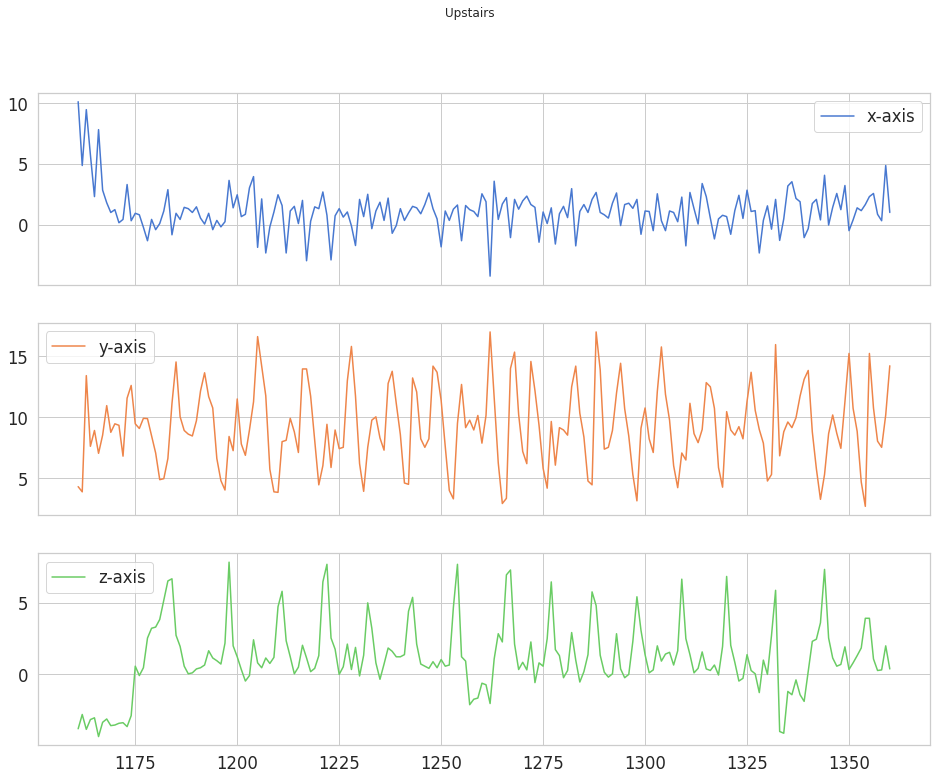

In [ ]:
plot_activity("Upstairs",df)

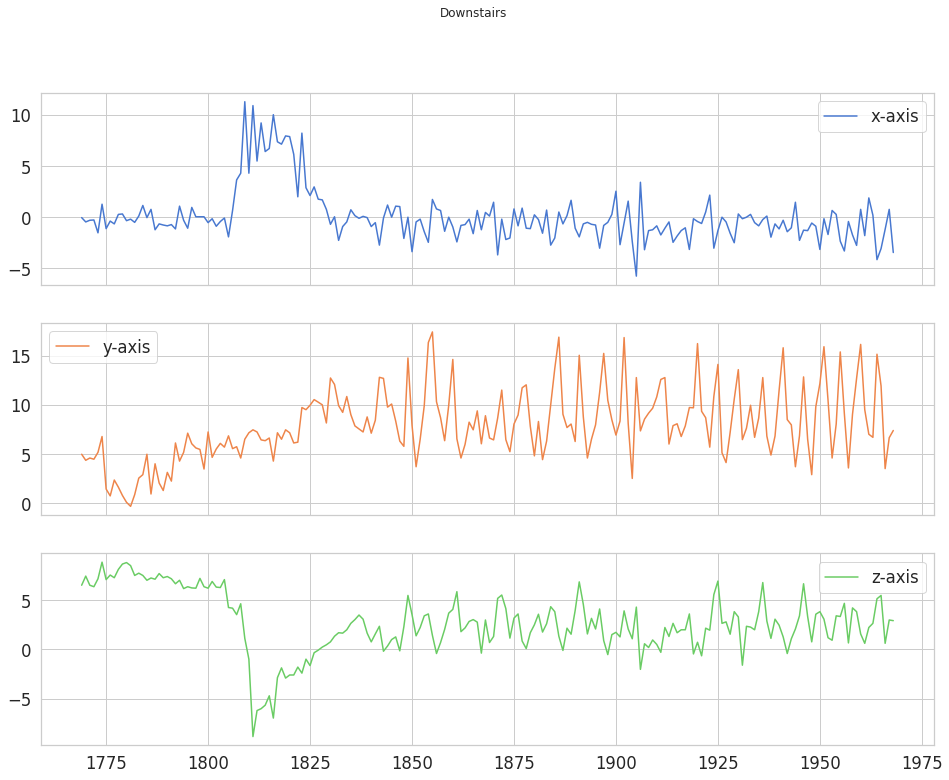

In [ ]:
plot_activity("Downstairs",df)

**Data preprocessing**
---


*  Modelling time series 
*  LSTM RNN
*  200 training sample sequence
*  Dividing the whole data into multiple slices


In [ ]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
  xs = df['x-axis'].values[i:i + N_TIME_STEPS]
  ys = df['y-axis'].values[i:i + N_TIME_STEPS]
  zs = df['z-axis'].values[i:i + N_TIME_STEPS]
  label = stats.mode(df['activity'][i:i + N_TIME_STEPS])
  label = label[0][0] # to get actual value of mode
  segments.append([xs, ys, zs]) # provide value append in sequre breakate
  labels.append(label)

In [ ]:
np.array(segments).shape

(54901, 3, 200)

**Transforming shape of segments**
---

In [ ]:
reshaped_segments = np.array(segments, dtype=np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
reshaped_segments.shape

(54901, 200, 3)

**Encoding of labels(Walking, Sitting, Jogging etc.)**
---

In [ ]:
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32) #pd.getdummies is used for one hot encoding #get_dummies function of pandas is used for one hot encoding 


In [ ]:
print(labels)
print(labels.shape)

[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
(54901, 6)


Finally, let's split the data into training and test(20%) set:


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
len(X_train)

43920

In [ ]:
len(X_test)

10981

**Building the model**
---
* 2 fully-connected and 2 LSTM layers
* 64 units each

In [ ]:
N_CLASSES = 6
N_HIDDEN_UNITS = 64 #LSTM layers

In [ ]:
import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()
def create_LSTM_model(inputs):
  W = {
      'hidden': tf.Variable(tf.random_normal([N_FEATURES,N_HIDDEN_UNITS])), #3*64
      'output': tf.Variable(tf.random_normal([N_FEATURES,N_HIDDEN_UNITS])) # 64*6
  }
  biases = {
     'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),  #64
     'output': tf.Variable(tf.random_normal([N_CLASSES]))        #6
      }
 
  X = tf.transpose(inputs,[1, 0, 2])
  X = tf.reshape(X, [-1,N_FEATURES])
  hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
  hidden = tf.split(hidden, N_TIME_STEPS, 0)
  #stack 2 LSTM LAYERS
  lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias= 1.0) for _ in range(2)] #create 2 LSTM LAYERS
  lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers) # Stacks them
  outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32) # Actually creates a LSTM network out of LSTM layers
  # Get output for the last time step
  lstm_last_output = outputs[-1]
  return tf.matmul(lstm_last_output, W['output']) + biases['output']



Instructions for updating:
non-resource variables are not supported in the long term


**Creating Placeholders:**
---

In [ ]:
tf.reset_default_graph() # to clear default graph
tf.compat.v1.disable_eager_execution()
X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input") # X values that must be fed using feed diet
Y = tf.placeholder(tf.float32, [None, N_CLASSES]) #Y values that must be fed using feed dict


**Creating the model:**
---


In [ ]:
pred_Y = create_LSTM_model(X)
pred_softmax = tf.nn.softmax(pred_Y, name="y_")


AttributeError: ignored